# BOF

In [1]:
%%html
<style>
    body {
        --vscode-font-family: 'NanumGothic';
        line-height: 1.5;
        
    }
</style>

In [2]:
import os
print(os.getcwd())

import warnings
warnings.filterwarnings(action='ignore') # 'default'

import gc
gc.collect()

import pandas as pd
# pd.set_option('display.max_rows', None) # pd.options.display.max_rows = 60
pd.set_option('display.max_columns', None) # pd.options.display.max_columns = 20

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'last_expr' # 'all'

from matplotlib import font_manager, rc
font_path = 'C:/Windows/Fonts/NanumGothic.TTF'
font_name = font_manager.FontProperties(fname = font_path).get_name()
rc('font', family = font_name)

import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False

# %matplotlib inline

c:\Users\soono\OneDrive\_프로젝트_\2023 BigContest


In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from tqdm import tqdm_notebook

In [4]:
import re
from datetime import datetime
import holidays

In [5]:
data = pd.read_csv('_데이터셋/2023빅콘테스트_어드밴스드리그_예술의전당.csv')

In [6]:
data = data[data['place']=='콘서트홀'].reset_index(drop=True)

In [7]:
data = data.drop_duplicates()

# 기본적인 처리

In [8]:
data = data.rename(columns={'performance_code':'code',
                            'discount_type':'dc',
                            'ticket_cancel':'cancel',
                            'play_date':'date'})

data['date'] = pd.to_datetime(data['date'], format='%Y%m%d')
data['pre_open_date'] = pd.to_datetime(data['pre_open_date'], format='%Y%m%d')
data['open_date'] = pd.to_datetime(data['open_date'], format='%Y%m%d')
data['tran_date'] = pd.to_datetime(data['tran_date'], format='%Y%m%d')

data['play_st_time'] = data['play_st_time'].apply(lambda x: str(x).zfill(4))
data['play_st_time'] = pd.to_datetime(data['play_st_time'], format='%H%M').dt.strftime('%H:%M')
data['tran_time'] = data['tran_time'].apply(lambda x: str(x).zfill(4))
data['tran_time'] = pd.to_datetime(data['tran_time'], format='%H%M').dt.strftime('%H:%M')

data['id'] = data['code'].astype(str) + '_' + data['date'].astype(str) # 식별자
data['tran-open'] = (data['tran_date'] - data['open_date']).dt.days # 예매 시작일 - 예매 거래일
data['tran_time_full'] = pd.to_datetime(data['tran_date'].astype(str) + ' ' + data['tran_time'].astype(str), format='%Y%m%d %H:%M') # 전체 예매 시각

In [9]:
tmp = data.groupby('id')[['play_st_time']].nunique()\
    .pipe(lambda df: df[df['play_st_time']>1]).reset_index(drop=False)

tmp = data[data['id'].isin(tmp.id)][['id','play_st_time']].drop_duplicates()\
    .sort_values(['id','play_st_time'])\
        .assign(i = [1,2] * len(tmp))
tmp['id_2'] = tmp['id'] + '_' + tmp['i'].astype(str)

data = pd.merge(data, tmp,
                 how='left', on=['id','play_st_time'])
data['id'] = np.where(~data['id_2'].isna(), data['id_2'], data['id'])
data.drop(columns=['id_2','i'], inplace=True)

# 멤버십 분해

In [10]:
unsigned_index = data[data.iloc[:,2:8].isna().all(axis=1)].index
data['signed'] = 1
data.loc[unsigned_index,'signed'] = 0
data.loc[data['signed']==1,'member_yn'] = 'Y'
data.loc[data['signed']==0,'member_yn'] = 'N'

data.rename(columns={'membership_type_1':'m1',
                     'membership_type_2':'m2',
                     'membership_type_3':'m3',
                     'membership_type_4':'m4',
                     'membership_type_5':'m5',
                     'membership_type_6':'m6'},
            inplace=True)

membership = ['골드','블루','그린','무료','싹틔우미','노블']
for m in tqdm(membership, total=len(membership)):
    data[m] = data.iloc[:,2:8].apply(lambda row: 1 if m in row.values else 0, axis=1)
data.drop(columns=['m1','m2','m3','m4','m5','m6'], inplace=True)

100%|██████████| 6/6 [03:37<00:00, 36.17s/it]


# 좌석 분해

In [11]:
con_seat = data[['seat']]

con_seat['floor'] = [s[0][:-1] for s in con_seat['seat'].str.split(' ')]
con_seat.loc[con_seat.seat.str.startswith('합창'),'floor'] = '0' # 합창석
con_seat['floor'] = con_seat['floor'].astype(int)

con_seat['tmp'] = [s[1] for s in con_seat['seat'].str.split(' ')]
con_seat['box'] = con_seat.loc[con_seat['tmp'].str.contains('BOX'),'tmp'].str[3:].astype(int)
con_seat['block'] = con_seat.loc[con_seat['tmp'].str.contains('블록'),'tmp'].str[0]
con_seat['col'] = con_seat.loc[con_seat['tmp'].str.contains('블록'),'tmp'].str[3:-1].astype(int)
con_seat['seat_num'] = [s[-1] for s in con_seat['seat'].str.split(' ')]
con_seat['seat_num'] = con_seat['seat_num'].astype(int)

con_seat = con_seat.rename(columns={'tmp':'cost_id'})

con_seat['cost_id_tmp'] = [s[3:] for s in con_seat['cost_id']]
con_seat['cost_id_tmp'] = con_seat['cost_id_tmp'].str.replace(r'열', '', regex=True)
con_seat['cost_id_tmp'] = con_seat['cost_id_tmp'].astype(int)
con_seat['cost_id_tmp'] = con_seat['cost_id_tmp'].astype(str).str.zfill(2)

con_seat['cost_id_final'] = [s[0][:3] + str(s[1]) for s in zip(con_seat['cost_id'], con_seat['cost_id_tmp'])]
con_seat['cost_id_final'] = [s + '열' if '블록' in s else s for s in con_seat['cost_id_final']]

con_seat = con_seat.drop(columns=['cost_id','cost_id_tmp'])
con_seat = con_seat.rename(columns={'cost_id_final':'cost_id'})

data[['floor','box','block','col','seat_num','cost_id']] = con_seat[['floor','box','block','col','seat_num','cost_id']]
data.loc[data['cost_id'].str.contains('BOX'),'cost_id'] = 'BOX' # BOX석은 층별로만
data['cost_id'] = data['code'].astype(str) + '_' + data['floor'].astype(str) + '층' + data['cost_id']

# 취소표 전환

In [12]:
df1 = data[data['cancel']==0].groupby(['id','seat']).size().reset_index(name='cnt')\
    .pipe(lambda df: df[df['cnt']>1]) # id-seat별로 cancel이 0인 행 중 중복행이 존재하는 경우
df2 = pd.merge(df1, data[['id','seat','tran_time_full','cancel']].reset_index(),
               how='left').set_index('index') # tran_time_full 추가
df3 = df2.sort_values(by='tran_time_full', ascending=False).groupby(['id','seat']).head(1) # 가장 나중의 예매 현황
df4 = df2[~df2.index.isin(df3.index)] # 가장 나중의 예매를 제외한 예매들
data.loc[data.index.isin(df4.index),'cancel'] = 2 # 취소표로 전환

# 객단가 추가

In [13]:
data = data.reset_index(drop=False)

data.loc[data['index']==546539,'dc'] = '골드회원 할인30%'
data.loc[data['index']==609019,'dc'] = '골드회원 할인30%'
data.loc[data['index']==943116,'dc'] = '골드회원 할인30%'
data.loc[data['index']==1027653,'dc'] = '골드회원 할인30%'
data.loc[data['index']==52919,'dc'] = '골드회원 할인15%'
data.loc[data['index']==465011, 'dc'] = '골드회원 할인15%'

data = data.drop(columns=['index'])

In [14]:
cond = (data['dc'].isin(['21년 4분기 시즌패키지 추가구매(2매)20%','21년 4분기 시즌패키지 추가 구매(2매)20%'])) & (data['price'].isin([63000,84000,35000]))
data.loc[cond,'dc'] = '21년 4분기 시즌패키지 추가구매(2매)30%'

cond = (data['dc']=='21년 4분기 시즌패키지 추가 구매(2매)20%') & (data['price'].isin([49000,70000,28000]))
data.loc[cond,'dc'] = '21년 4분기 시즌패키지 추가 구매(2매)30%'

cond = (data['dc']=='골드회원 할인10%') & (data['price'].isin([35000,84000]))
data.loc[cond,'dc'] = '골드회원 할인30%'

cond = (data['dc']=='골드회원 할인10%') & (data['price'].isin([50000,65000]))
data.loc[cond,'dc'] = '골드회원 할인50%'

cond = (data['dc']=='골드회원 할인15%') & (data['price'].isin([14000,35000]))
data.loc[cond,'dc'] = '골드회원 할인30%'

cond = (data['dc'].str.contains('10%')) & (data['price']==70000)
data.loc[cond,'price'] = 63000

## Cost 1

In [15]:
data['cost1'] = np.nan

In [16]:
yh = pd.read_csv('_All_Price.csv')
yh = yh.round(2)

In [17]:
# dc로부터 percent를 추출하고, percent를 곱해서 만든 값을 cost1으로
percent = data[['dc']].drop_duplicates()[data[['dc']].drop_duplicates().dc.str.endswith('%')]

pattern = r'(\d+%)'
percent['percent'] = percent['dc'].apply(lambda x: re.findall(pattern, x)[0] if re.findall(pattern, x) else None)
percent['percent'] = percent['percent'].str[:-1]
percent['percent'] = percent['percent'].astype(int)
percent['percent'] = percent['percent'] / 100
data = pd.merge(data, percent,
                how='left', on='dc').set_index(data.index)

data['cost1'] = data['price'] / (1 - data['percent'])
data.loc[data['dc']=='20,000원 할인','cost1'] = data.loc[data['dc']=='20,000원 할인','price'] + 20000
data.loc[data['dc']=='골드회원 할인10%_','cost1'] = data.loc[data['dc']=='골드회원 할인10%_','price'] / (1 - 0.1)
data.loc[data['dc']=='우리카드할인(1인1매)50%_','cost1'] = data.loc[data['dc']=='우리카드할인(1인1매)50%_','price'] / (1 - 0.5)

data['cost1'] = data['cost1'].round(2)

In [18]:
# dc가 일반이고 yh의 price에 존재하는 price는 그대로 cost1으로
cond = (data['dc']=='일반') & (data['price'].isin(yh['price']))
data.loc[cond,'cost1'] = data.loc[cond,'price']

## Cost 2

In [19]:
yhp = pd.DataFrame()
for c in yh.columns[:-1]:
    yhp = pd.concat([yhp, yh[c]], axis=0)

yhp = yhp.reset_index(drop=False)
yhp = yhp.rename(columns={0:'cost_van',
                          'index':'row'})
yhp['idx'] = [c for c in yh.columns[:-1] for _ in range(55)]
yhp = yhp.set_index('idx') 

# cost1을 1000으로 나눴을 때 나머지가 남지 않으면 그대로 cost1을 사용해서 cost2로
data['cost2'] = data['cost1']

# cost1을 1000으로 나눴을 때 나머지가 남으면 yh의 price에 매핑해 cost2로 (special case 2개 제외)
cond = yhp['cost_van'] % 1000 != 0 # yhp[cond][yhp.loc[cond,['cost_van']].duplicated(keep='last')]
tmp1 = yhp[cond &
           ~yhp['cost_van'].isin([64615.38,131666.67])] # special case 2개 제외
tmp1 = tmp1.merge(yh['price'].reset_index(),
                  how='left', left_on='row', right_on='index')
tmp1_dict = dict(zip(tmp1['cost_van'], tmp1['price']))
data['cost2'] = data['cost2'].replace(tmp1_dict)

In [20]:
fifty = {14000:15000,
         32000:33000,
         34000:35000,
         54000:55000,
         64000:65000,
         74000:75000,
         76000:77000,
         84000:85000,
         94000:95000,
         98000:99000}
con = data['dc'].str.contains('50%')
data.loc[con,'cost2'] = data.loc[con,'cost2'].replace(fifty)

In [21]:
cond = (data['dc'].str.contains('40%')) & (data['cost2']==131666.67)
data.loc[cond,'cost2'] = 132000

cond = (data['dc'].str.contains('35%')) & (data['cost2']==64615.38)
data.loc[cond,'cost2'] = 65000

con = data['cost2']==77777.78
data.loc[con,'price'] = 63000

In [22]:
def nogada(frms, ts):
    for i in range(len(frms)):
        cond = (data['dc']=='일반') & (data['cost2']==ts[i])
        ids = data[cond].id.unique()
        
        cond = (data.id.isin(ids)) & (data['cost2'].isin([frms[i],ts[i]]))
        tmp = data[cond].groupby('id')[['cost2']].nunique().reset_index(drop=False)
        
        cond = (data['id'].isin(tmp.id)) & (data['cost2'] == frms[i])
        data.loc[cond,'cost2'] = ts[i]

nogada(frms=[44000,65000,75000,120000,130000,132000], ts=[45000,66000,77000,121000,132000,133000])

In [23]:
tmp = data.groupby('id')[['cost2']].nunique()\
    .pipe(lambda df: df[df['cost2']>5]).sort_values('cost2', ascending=False)
data = data[~data['id'].isin(tmp.index)]

In [24]:
data.drop(columns=['cost1'], inplace=True)
data.rename(columns={'cost2':'cost'}, inplace=True)

In [25]:
data.groupby('id')[['cost']].nunique()\
    .value_counts('cost').to_frame(name='count').sort_index()

,count
cost,
0,61
1,9
2,25
3,159
4,321
5,169


In [26]:
data = data[data['cost']!=0] # 83행 제외

In [27]:
data.to_csv('data_v3_1_tmp1.csv', index=False)

# 좌석 등급화

In [5]:
data = pd.read_csv('data_v3_1_tmp1.csv')

In [6]:
cr = data.drop_duplicates(['id','cost'])[['id','cost']]

cr['cost_rnk'] = data.drop_duplicates(['id','cost']).sort_values(['id','cost']).groupby('id')[['cost']].rank(method='min')

cr = cr.groupby('id')[['cost']].nunique()\
    .rename(columns={'cost':'cost_cnt'}).reset_index()\
        .merge(cr, how='left')

In [7]:
cr

,id,cost_cnt,cost,cost_rnk
0,1002_2019-06-23,4,NaN,NaN
1,1002_2019-06-23,4,120000.0,4.0
2,1002_2019-06-23,4,90000.0,3.0
3,1002_2019-06-23,4,50000.0,1.0
4,1002_2019-06-23,4,70000.0,2.0
...,...,...,...,...
3396,996_2022-11-05,4,NaN,NaN
3397,996_2022-11-05,4,55000.0,1.0
3398,996_2022-11-05,4,99000.0,3.0
3399,996_2022-11-05,4,121000.0,4.0


In [8]:
cr['rnk'] = np.nan

# Five
rnk = {1:'C', 2:'B', 3:'A', 4:'S', 5:'R'}
cr.loc[cr['cost_cnt']==5,'rnk'] = cr.loc[cr['cost_cnt']==5,'cost_rnk'].replace(rnk)

# Four
rnk = {1:'B', 2:'A', 3:'S', 4:'R'}
cr.loc[cr['cost_cnt']==4,'rnk'] = cr.loc[cr['cost_cnt']==4,'cost_rnk'].replace(rnk)

# Three
rnk = {1:'A', 2:'S', 3:'R'}
cr.loc[cr['cost_cnt']==3,'rnk'] = cr.loc[cr['cost_cnt']==3,'cost_rnk'].replace(rnk)

# Two
rnk = {1:'S', 2:'R'}
cr.loc[cr['cost_cnt']==2,'rnk'] = cr.loc[cr['cost_cnt']==2,'cost_rnk'].replace(rnk)

# One
rnk = {1:'R'}
cr.loc[cr['cost_cnt']==1,'rnk'] = cr.loc[cr['cost_cnt']==1,'cost_rnk'].replace(rnk)

# Zero
cr['rnk'] = cr['rnk'].fillna('N')

In [9]:
cr = cr.drop(columns=['cost_rnk'])
cr = cr.rename(columns={'cost_cnt':'total_rnk'})
cr = cr.rename(columns={'rnk':'seat_rnk'})

In [10]:
cr

,id,total_rnk,cost,seat_rnk
0,1002_2019-06-23,4,NaN,N
1,1002_2019-06-23,4,120000.0,R
2,1002_2019-06-23,4,90000.0,S
3,1002_2019-06-23,4,50000.0,B
4,1002_2019-06-23,4,70000.0,A
...,...,...,...,...
3396,996_2022-11-05,4,NaN,N
3397,996_2022-11-05,4,55000.0,B
3398,996_2022-11-05,4,99000.0,S
3399,996_2022-11-05,4,121000.0,R


In [11]:
data = data.merge(cr, how='left')

# 할인 타입 정리

In [12]:
data['dc_origin'] = data['dc']

In [13]:
dcs = data.dc.unique()

In [14]:
# 공연진행석 제외
data = data[data['dc']!='공연진행석']
dcs = dcs[dcs!='공연진행석']

In [15]:
# 기획사, 초대권, 일반 #

# 기획사
tmp = data[(data.dc.str.contains('기획'))]
data.loc[data.index.isin(tmp.index),'dc'] = '기획사할인'
dcs = dcs[~np.isin(dcs, tmp.dc.unique())]

# 초대권
tmp = data[(data.dc.str.contains('초대'))]
data.loc[data.index.isin(tmp.index),'dc'] = '초대권할인'
dcs = dcs[~np.isin(dcs, tmp.dc.unique())]

data.loc[data['dc']=='［초대권］','dc'] = '초대권'
dcs = dcs[dcs!='초대권']

# 일반
tmp = data[(data.dc.str.contains('일반|일반석|일반판매석'))]
data.loc[data.index.isin(tmp.index),'dc'] = '일반'
dcs = dcs[~np.isin(dcs, tmp.dc.unique())]

In [16]:
# 회원 관련 #

# 정기회원
tmp = data[(data.dc.str.contains('정기회원'))]
data.loc[data.index.isin(tmp.index),'dc'] = '정기회원할인'
dcs = dcs[~np.isin(dcs, tmp.dc.unique())]

# 유료회원
tmp = data[(data.dc.str.contains('유료회원')) &
           ~(data.dc.str.contains('국립합창단'))]
data.loc[data.index.isin(tmp.index),'dc'] = '유료회원할인'
dcs = dcs[~np.isin(dcs, tmp.dc.unique())]

tmp = data[(data.dc.str.contains('법인'))]
data.loc[data.index.isin(tmp.index),'dc'] = '골드법인할인'
dcs = dcs[~np.isin(dcs, tmp.dc.unique())]

tmp = data[(data.dc.str.contains('골드')) &
           ~(data.dc.str.contains('법인'))]
data.loc[data.index.isin(tmp.index),'dc'] = '골드할인'
dcs = dcs[~np.isin(dcs, tmp.dc.unique())]

tmp = data[(data.dc.str.contains('블루'))]
data.loc[data.index.isin(tmp.index),'dc'] = '블루할인'
dcs = dcs[~np.isin(dcs, tmp.dc.unique())]

tmp = data[(data.dc.str.contains('그린'))]
data.loc[data.index.isin(tmp.index),'dc'] = '그린할인'
dcs = dcs[~np.isin(dcs, tmp.dc.unique())]

# 무료회원
tmp = data[(data.dc.str.contains('싹틔우미'))]
data.loc[data.index.isin(tmp.index),'dc'] = '싹틔우미할인'
dcs = dcs[~np.isin(dcs, tmp.dc.unique())]

tmp = data[(data.dc.str.contains('노블'))]
data.loc[data.index.isin(tmp.index),'dc'] = '노블할인'
dcs = dcs[~np.isin(dcs, tmp.dc.unique())]

In [17]:
# 사람 관련 #

# 학생
tmp = data[(data.dc.str.contains('초|중|고|대|학생|청소년|수험')) &
           ~(data.dc.str.contains('장애|중앙|박규희|정기|초대|지방|보고|우대|카드|대전'))]
data.loc[data.index.isin(tmp.index),'dc'] = '학생할인'
dcs = dcs[~np.isin(dcs, tmp.dc.unique())]

# 청년
tmp = data[(data.dc.str.contains('청년|29세'))]
data.loc[data.index.isin(tmp.index),'dc'] = '청년할인'
dcs = dcs[~np.isin(dcs, tmp.dc.unique())]

# 경로
tmp = data[(data.dc.str.contains('실버|65|경로|70'))]
data.loc[data.index.isin(tmp.index),'dc'] = '경로할인'
dcs = dcs[~np.isin(dcs, tmp.dc.unique())]

# 군인
tmp = data[(data.dc.str.contains('군인'))]
data.loc[data.index.isin(tmp.index),'dc'] = '군인할인'
dcs = dcs[~np.isin(dcs, tmp.dc.unique())]

# 예비군
tmp = data[(data.dc.str.contains('예비군'))]
data.loc[data.index.isin(tmp.index),'dc'] = '예비군할인'
dcs = dcs[~np.isin(dcs, tmp.dc.unique())]

# 직장인
tmp = data[(data.dc.str.contains('직장'))]
data.loc[data.index.isin(tmp.index),'dc'] = '직장인할인'
dcs = dcs[~np.isin(dcs, tmp.dc.unique())]

# 임산부
tmp = data[(data.dc.str.contains('임산'))]
data.loc[data.index.isin(tmp.index),'dc'] = '임산부할인'
dcs = dcs[~np.isin(dcs, tmp.dc.unique())]

# 장애인/국가유공자
tmp = data[(data.dc.str.contains('장애|국가|의상자|의사상자'))]
data.loc[data.index.isin(tmp.index),'dc'] = '장애인/국가유공자할인'
dcs = dcs[~np.isin(dcs, tmp.dc.unique())]

# 가족
tmp = data[(data.dc.str.contains('가족|패밀리'))]
data.loc[data.index.isin(tmp.index),'dc'] = '가족할인'
dcs = dcs[~np.isin(dcs, tmp.dc.unique())]

# 예술인
tmp = data[(data.dc.str.contains('예술|연주자'))]
data.loc[data.index.isin(tmp.index),'dc'] = '예술인할인'
dcs = dcs[~np.isin(dcs, tmp.dc.unique())]

# 교직원
tmp = data[(data.dc.str.contains('교직원'))]
data.loc[data.index.isin(tmp.index),'dc'] = '교직원할인'
dcs = dcs[~np.isin(dcs, tmp.dc.unique())]

# 보건의료인
tmp = data[(data.dc.str.contains('보건'))]
data.loc[data.index.isin(tmp.index),'dc'] = '의료인할인'
dcs = dcs[~np.isin(dcs, tmp.dc.unique())]

# 마니아
tmp = data[(data.dc.str.contains('마니아|30주년'))]
data.loc[data.index.isin(tmp.index),'dc'] = '마니아할인'
dcs = dcs[~np.isin(dcs, tmp.dc.unique())]

In [18]:
# 예매 관련 #

# 얼리버드
tmp = data[(data.dc.str.contains('조기|얼리'))]
data.loc[data.index.isin(tmp.index),'dc'] = '조기예매할인'
dcs = dcs[~np.isin(dcs, tmp.dc.unique())]

# 당일
tmp = data[(data.dc.str.contains('당일'))]
data.loc[data.index.isin(tmp.index),'dc'] = '당일할인'
dcs = dcs[~np.isin(dcs, tmp.dc.unique())]

# 타임세일
tmp = data[(data.dc.str.contains('타임'))]
data.loc[data.index.isin(tmp.index),'dc'] = '타임세일'
dcs = dcs[~np.isin(dcs, tmp.dc.unique())]

# 단체
tmp = data[(data.dc.str.contains('단체'))]
data.loc[data.index.isin(tmp.index),'dc'] = '단체할인'
dcs = dcs[~np.isin(dcs, tmp.dc.unique())]

# 웰컴
tmp = data[(data.dc.str.contains('웰컴|기구매|기관람'))]
data.loc[data.index.isin(tmp.index),'dc'] = '웰컴할인'
dcs = dcs[~np.isin(dcs, tmp.dc.unique())]

# 재관람
tmp = data[(data.dc.str.contains('재관람|재구매|재예매|보고'))]
data.loc[data.index.isin(tmp.index),'dc'] = '재관람할인'
dcs = dcs[~np.isin(dcs, tmp.dc.unique())]

# 차액
tmp = data[(data.dc.str.contains('차액'))]
data.loc[data.index.isin(tmp.index),'dc'] = '차액할인'
dcs = dcs[~np.isin(dcs, tmp.dc.unique())]

# 예매권
tmp = data[(data.dc.str.contains('예매권'))]
data.loc[data.index.isin(tmp.index),'dc'] = '예매권할인'
dcs = dcs[~np.isin(dcs, tmp.dc.unique())]

# 카드
tmp = data[(data.dc.str.contains('카드'))]
data.loc[data.index.isin(tmp.index),'dc'] = '카드할인'
dcs = dcs[~np.isin(dcs, tmp.dc.unique())]

In [19]:
# 기관 (후원 회원) 관련 #

# 후원회원
tmp = data[(data.dc.str.contains('후원회원')) &
           ~(data.dc.str.contains('KBS'))]
data.loc[data.index.isin(tmp.index),'dc'] = '후원회원할인'
dcs = dcs[~np.isin(dcs, tmp.dc.unique())]

# 단원
tmp = data[(data.dc.str.contains('단원'))]
data.loc[data.index.isin(tmp.index),'dc'] = '단원할인'
dcs = dcs[~np.isin(dcs, tmp.dc.unique())]

# 국립합창단 유료회원
tmp = data[(data.dc.str.contains('국립'))]
data.loc[data.index.isin(tmp.index),'dc'] = '국립합창단유료회원할인'
dcs = dcs[~np.isin(dcs, tmp.dc.unique())]

# KBS 교향악단
tmp = data[(data.dc.str.contains('Lang|lang'))]
data.loc[data.index.isin(tmp.index),'dc'] = 'KLang할인'
dcs = dcs[~np.isin(dcs, tmp.dc.unique())]

# KBS 교향악단 후원회원
tmp = data[(data.dc.str.contains('KBS'))]
data.loc[data.index.isin(tmp.index),'dc'] = 'KBS교향악단후원회원할인'
dcs = dcs[~np.isin(dcs, tmp.dc.unique())]

# KOSYMI
tmp = data[(data.dc.str.contains('KO'))]
data.loc[data.index.isin(tmp.index),'dc'] = 'KOSYMI할인'
dcs = dcs[~np.isin(dcs, tmp.dc.unique())]

# 심포니회원
tmp = data[(data.dc.str.contains('심포니'))]
data.loc[data.index.isin(tmp.index),'dc'] = '심포니회원할인'
dcs = dcs[~np.isin(dcs, tmp.dc.unique())]

# 관계자
tmp = data[(data.dc.str.contains('스탭|스텝|출연|관계|직원')) &
           ~(data.dc.str.contains('교직원|시향|하비에르'))]
data.loc[data.index.isin(tmp.index),'dc'] = '관계자할인'
dcs = dcs[~np.isin(dcs, tmp.dc.unique())]

In [20]:
# 공공기관 관련 #

# 강남구
tmp = data[(data.dc.str.contains('강남'))]
data.loc[data.index.isin(tmp.index),'dc'] = '강남구할인'
dcs = dcs[~np.isin(dcs, tmp.dc.unique())]

# 경기도민
tmp = data[(data.dc.str.contains('경기도민'))]
data.loc[data.index.isin(tmp.index),'dc'] = '경기도민할인'
dcs = dcs[~np.isin(dcs, tmp.dc.unique())]

# 경기필
tmp = data[(data.dc.str.contains('경기필'))]
data.loc[data.index.isin(tmp.index),'dc'] = '경기필카톡친구할인'
dcs = dcs[~np.isin(dcs, tmp.dc.unique())]

# 문화릴레이
tmp = data[(data.dc.str.contains('문화릴레이'))]
data.loc[data.index.isin(tmp.index),'dc'] = '문화릴레이할인'
dcs = dcs[~np.isin(dcs, tmp.dc.unique())]

# 문화누리
tmp = data[(data.dc.str.contains('문화누리'))]
data.loc[data.index.isin(tmp.index),'dc'] = '문화누리할인'
dcs = dcs[~np.isin(dcs, tmp.dc.unique())]

# 문화햇살
tmp = data[(data.dc.str.contains('문화햇살'))]
data.loc[data.index.isin(tmp.index),'dc'] = '문화햇살할인'
dcs = dcs[~np.isin(dcs, tmp.dc.unique())]

In [21]:
# 시기 관련 #

# 시기
tmp = data[(data.dc.str.contains('GOOD|가을|가정|발렌|신년|추석|여름방학|토끼|호랑이'))]
data.loc[data.index.isin(tmp.index),'dc'] = '시기별특별할인'
dcs = dcs[~np.isin(dcs, tmp.dc.unique())]

# 연도별 분기(상하반기) 패키지 추가 구매
tmp = data[(data.dc.str.contains('패키지')) &
           ~(data.dc.str.contains('호두까기'))]
data.loc[data.index.isin(tmp.index),'dc'] = '분기패키지추가구매할인'
dcs = dcs[~np.isin(dcs, tmp.dc.unique())]

# 기념일
tmp = data[(data.dc.str.contains('화이트데이'))]
data.loc[data.index.isin(tmp.index),'dc'] = '기념일할인'
dcs = dcs[~np.isin(dcs, tmp.dc.unique())]

# 코로나
tmp = data[(data.dc.str.contains('코로나|백신'))]
data.loc[data.index.isin(tmp.index),'dc'] = '코로나할인'
dcs = dcs[~np.isin(dcs, tmp.dc.unique())]

In [22]:
# 공연 관련 #

# 음악가
tmp = data[(data.dc.str.contains('라흐마니|전곡|베토벤|박규희'))]
data.loc[data.index.isin(tmp.index),'dc'] = '음악가특별할인'
dcs = dcs[~np.isin(dcs, tmp.dc.unique())]

# 호두까기인형
tmp = data[(data.dc.str.contains('호두까기'))]
data.loc[data.index.isin(tmp.index),'dc'] = '호두까기인형할인'
dcs = dcs[~np.isin(dcs, tmp.dc.unique())]

In [23]:
# 특별 (이벤트 및 제휴 기관 회원 멤버십) 관련 #

# 특별
tmp = data[(data.dc.str.contains('특별'))]
data.loc[data.index.isin(tmp.index),'dc'] = '기타특별할인'
dcs = dcs[~np.isin(dcs, tmp.dc.unique())]

# 쿠폰
tmp = data[(data.dc.str.contains('쿠폰'))]
data.loc[data.index.isin(tmp.index),'dc'] = '쿠폰할인'
dcs = dcs[~np.isin(dcs, tmp.dc.unique())]

# 이벤트 및 제휴 기관 회원 멤버십
tmp = data[(data.dc.str.contains('또모|코심|서포터즈|기부|주보|H-Point|하비에르|다이내믹|도서|클립서비스|아이랑노랑|블랙프라이데이|콘서트|코코프렌즈|카카오톡|KT멤버십|멜론'))]
data.loc[data.index.isin(tmp.index),'dc'] = '이벤트특별할인'
dcs = dcs[~np.isin(dcs, tmp.dc.unique())]

# 특정 유료 티켓
tmp = data[(data.dc.str.contains('티켓'))]
data.loc[data.index.isin(tmp.index),'dc'] = '유료티켓소지할인'
dcs = dcs[~np.isin(dcs, tmp.dc.unique())]

# 홍보 (및 홍보진행석)
tmp = data[(data.dc.str.contains('홍보|특판'))]
data.loc[data.index.isin(tmp.index),'dc'] = '홍보할인'
dcs = dcs[~np.isin(dcs, tmp.dc.unique())]

# 블라인드
tmp = data[(data.dc.str.contains('블라인드'))]
data.loc[data.index.isin(tmp.index),'dc'] = '블라인드할인'
dcs = dcs[~np.isin(dcs, tmp.dc.unique())]

In [24]:
# 기업 관련 #

tmp = data[(data.dc.str.contains('한화|중앙일보|신한은행'))]
data.loc[data.index.isin(tmp.index),'dc'] = '기업할인'
dcs = dcs[~np.isin(dcs, tmp.dc.unique())]

tmp = data[(data.dc.str.contains('신세계석|기업석|KT석'))]
data.loc[data.index.isin(tmp.index),'dc'] = '기업석'
dcs = dcs[~np.isin(dcs, tmp.dc.unique())]

In [25]:
data.dc.nunique() # dcs

58

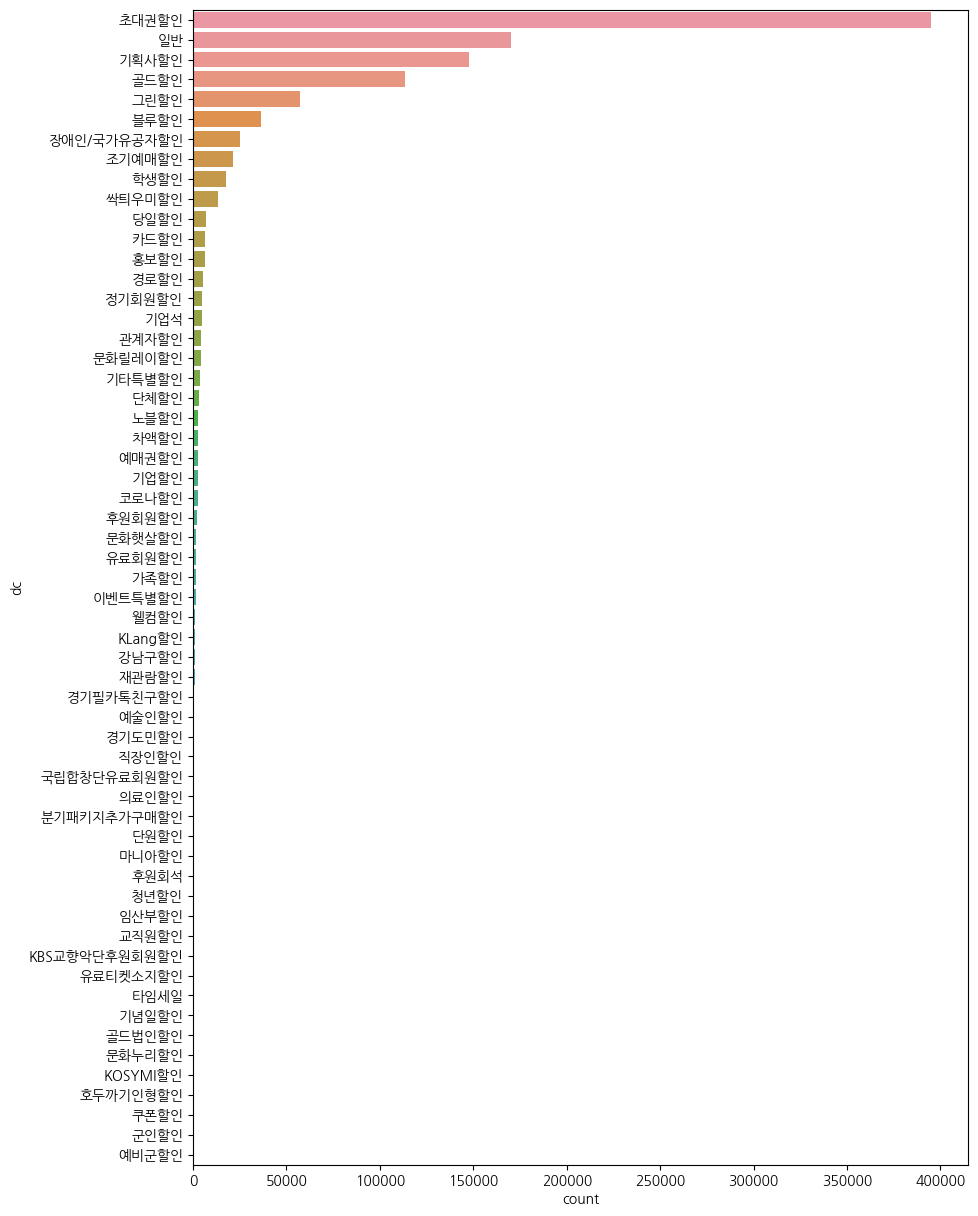

In [26]:
fig, ax = plt.subplots(figsize=(10,15))
sns.countplot(y='dc', data=data, ax=ax,
              order=data.dc.value_counts().index)
plt.show()

# 장르 정리

In [27]:
data.loc[data['id']=='229_2022-11-20','genre'] = '교항곡'
data.loc[data['id']=='2215_2019-07-14','genre'] = '클래식'

data = data[~data['genre'].isna()]

In [28]:
# genres = ['교향곡','클래식','합창','독주','성악','실내악','콘서트','오페라']
# data['genre1'] = data['genre'].apply(lambda x: x if x in genres else '나머지')

In [29]:
# data = data.rename(columns={'genre':'genre_old',
#                             'genre1':'genre'})

# 요일과 시간 보완

In [30]:
# 요일과 시간
data['play_weekday'] = pd.to_datetime(data['date']).dt.weekday
# weekday_dict = {0:'Mon',
#                 1:'Tue',
#                 2:'Wed',
#                 3:'Thu',
#                 4:'Fri',
#                 5:'Sat',
#                 6:'Sun'}
# data['play_weekday'] = data['play_weekday'].replace(weekday_dict)
data['play_hour'] = pd.to_datetime(data['play_st_time']).dt.hour
data['hour_cat'] = np.where(data['play_hour']<14, 'launch',
                            np.where(data['play_hour']<19, 'afternoon', 'evening'))

# 공휴일
data['date'] = pd.to_datetime(data['date'])
holi = holidays.KR(years=[2018,2019,2020,2021,2022,2023])
data['holiday'] = np.where(data['date'].isin(holi), 1, 0)

# 코로나 기간 여부 (2020.03.22~2022.04.18)
data['date'] = pd.to_datetime(data['date'])
data['covid'] = 0
cond = (data['date']>=pd.to_datetime('2020-03-22')) & (data['date']<=pd.to_datetime('2022-04-18'))
data.loc[cond,'covid'] =1 

In [31]:
data.columns

Index(['age', 'gender', 'tran_date', 'tran_time', 'date', 'play_st_time',
       'seat', 'price', 'cancel', 'dc', 'code', 'pre_open_date', 'open_date',
       'genre', 'place', 'running_time', 'intermission', 'member_yn', 'id',
       'tran-open', 'tran_time_full', 'signed', '골드', '블루', '그린', '무료', '싹틔우미',
       '노블', 'floor', 'box', 'block', 'col', 'seat_num', 'cost_id', 'percent',
       'cost', 'total_rnk', 'seat_rnk', 'dc_origin', 'play_weekday',
       'play_hour', 'hour_cat', 'holiday', 'covid'],
      dtype='object')

# EOF : Final Output [data_v3_1]

In [32]:
data_final = data[['age','gender','골드','블루','그린','무료','싹틔우미','노블','member_yn',
                   'id','code','date','genre','total_rnk','pre_open_date','open_date','play_st_time','play_weekday','hour_cat','holiday','covid','running_time','intermission',
                   'seat','seat_rnk','dc','dc_origin','price','cost','floor','box','block','col','seat_num','cancel',
                   'tran_date','tran_time','tran_time_full','tran-open']] # drop place, percent, cost_id, signed, play_hour

In [33]:
print(data.shape, data_final.shape)

(1051394, 44) (1051394, 39)


In [34]:
data_final.to_csv('data_v3_1.csv', index=False)